In [ ]:
TRACKING_SERVER_HOST = "" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [ ]:
https://www.kaggle.com/datasets/unsdsn/world-happiness

In [33]:
numerical = ['standard_error', 'economy_gdp_per_capita', 'family',
       'health_life_expectancy', 'freedom', 'trust_government_corruption',
       'generosity', 'dystopia_residual']
categorical = ['country', 'region']
numerical+categorical

['standard_error',
 'economy_gdp_per_capita',
 'family',
 'health_life_expectancy',
 'freedom',
 'trust_government_corruption',
 'generosity',
 'dystopia_residual',
 'country',
 'region']

In [30]:
import pandas as  pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import RobustScaler
import pickle
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [27]:



target = 'median_house_value'

numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']

categorical = ['ocean_proximity']

def dump_pickle(obj, filename: str):
    with open(filename, "wb") as f_out:
        return pickle.dump(obj, f_out)
    
def load_pickle(filename):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)

def read(filename:str)->pd.DataFrame:
    "Load a csv file from the file path, returning a DataFrame."
    df = pd.read_csv(f'../data/raw/{filename}')
    return df

def prepare(df:pd.DataFrame, fit: bool = False)->pd.DataFrame:
    "Prepare a raw dataframe, returning a prepare DataFrame"
    
    
    if fit:
        dv = DictVectorizer()
        scaler = RobustScaler().set_output(transform="pandas")
        df_scaled = scaler.fit_transform(df[numerical])
        
        dicts = df[categorical].to_dict(orient='records')
        dv = DictVectorizer()
        ohe = pd.DataFrame(dv.fit_transform(dicts).todense(), columns=dv.feature_names_)
         
        df_prepare = pd.concat([ohe,df_scaled,df[target]], axis=1)
        
        #dump_pickle(dv,'../data/preprocess/dv.pkl')
        #dump_pickle(scaler,'../data/preprocess/scaler.pkl')
        return df_prepare
        
    else:
        dv = load_pickle("../data/preprocess/dv.pkl")
        scaler = load_pickle("../data/preprocess/scaler.pkl")
        
        df_scaled = scaler.transform(df[numerical])
        
        dicts = df[categorical].to_dict(orient='records')
        ohe = pd.DataFrame(dv.transform(dicts).todense(), columns=dv.feature_names_)

        df_prepare = pd.concat([ohe,df_scaled,df[target]], axis=1)
        return df_prepare
    
    
def run(df_train: pd.DataFrame, df_test: pd.DataFrame, num_trials=100):
    X_train = df_train.drop(columns=target)
    X_test = df_test.drop(columns=target)

    y_train = df_train[target].values
    y_test = df_test[target].values

    best_loss = float('inf')
    best_y_pred = None

    def objective(params):
        nonlocal best_loss, best_y_pred

        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)

        if rmse < best_loss:
            best_loss = rmse
            best_y_pred = y_pred

        return {'loss': rmse, 'status': STATUS_OK}

    search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
        'random_state': 42
    }

    rstate = np.random.default_rng(42)  # for reproducible results
    fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )

    return best_y_pred, y_test



In [14]:
raw_housing = read('housing.csv')


In [15]:
raw_housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [16]:
raw_housing['total_bedrooms'] = raw_housing['total_bedrooms'].fillna(raw_housing['total_bedrooms'].median())

In [18]:
raw_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [21]:
prepare_housing = prepare(raw_housing,fit=True)


<Axes: ylabel='Frequency'>

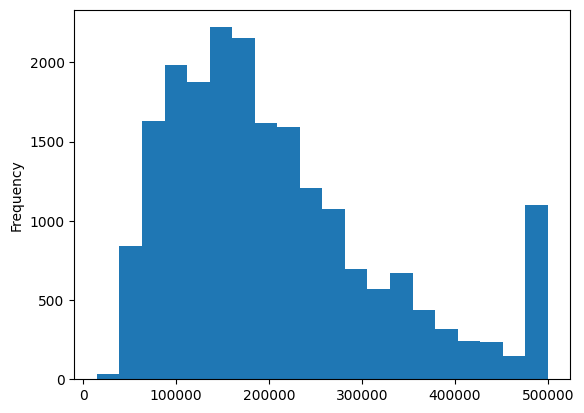

In [23]:
prepare_housing[target].plot.hist(bins=20)

In [ ]:
scaler = load_pickle("../data/preprocess/scaler.pkl")
scaler.feature_names_in_

In [158]:
dv = load_pickle("../data/preprocess/dv.pkl")
dv.feature_names_

['region=Australia and New Zealand',
 'region=Central and Eastern Europe',
 'region=Eastern Asia',
 'region=Latin America and Caribbean',
 'region=Middle East and Northern Africa',
 'region=North America',
 'region=Southeastern Asia',
 'region=Southern Asia',
 'region=Sub-Saharan Africa',
 'region=Western Europe']

In [28]:
best_y_pred, y_test = run(prepare_housing,prepare_housing,20)

100%|██████████| 20/20 [00:46<00:00,  2.34s/trial, best loss: 24462.40034711335] 


C:\Users\user\AppData\Local\Temp\ipykernel_1900\2894624454.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(best_y_pred, label='prediction')
C:\Users\user\AppData\Local\Temp\ipykernel_1900\2894624454.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, label='actual')


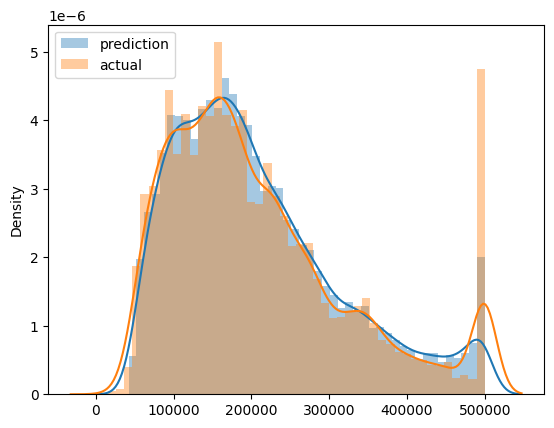

In [32]:
sns.distplot(best_y_pred, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()

In [159]:
train(prepare_data_2015,prepare_data_2015)

0.7285142081955036

In [160]:
train(prepare_data_2015,prepare_data_2016)

0.7078153497678884

<Axes: ylabel='Frequency'>

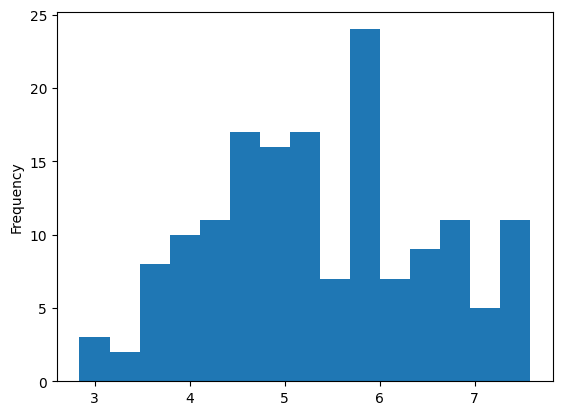

In [22]:
df_train['happiness_score'].plot.hist(bins=15)

In [100]:
train(prepare_data_2015,prepare_data_2015)

KeyError: "['country', 'region'] not in index"

0.8174997785535861

In [17]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mse =mean_squared_error(y_test, y_pred, squared=False)

,Family,Health (Life Expectancy),Freedom
0,1.34951,0.94143,0.66557
1,1.40223,0.94784,0.62877
2,1.36058,0.87464,0.64938
3,1.33095,0.88521,0.66973
4,1.32261,0.90563,0.63297
...,...,...,...
153,0.77370,0.42864,0.59201
154,0.35386,0.31910,0.48450
155,0.47489,0.72193,0.15684
156,0.41587,0.22396,0.11850


In [14]:
df.columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual'],
      dtype='object')